# Inference pipeline

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export 
from xview2comp.nb_03 import *

### Pre-disaster and post-disaster image file paths

In [3]:
SOURCE = Path('data/test/images')
SOURCE.ls()[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_post_00171.png'),
 PosixPath('data/test/images/test_pre_00064.png')]

In [4]:
preimgs = pre_img_fpaths(get_image_files(SOURCE))

In [5]:
posimgs = [pre2post_fpath(o) for o in preimgs]

In [6]:
len(preimgs), len(posimgs)

(933, 933)

In [7]:
preimgs[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_pre_00064.png'),
 PosixPath('data/test/images/test_pre_00091.png')]

In [8]:
posimgs[:3]

[PosixPath('data/test/images/test_post_00831.png'),
 PosixPath('data/test/images/test_post_00064.png'),
 PosixPath('data/test/images/test_post_00091.png')]

### Building detection

In [9]:
#seglearn.load('sz1024_bs2_resnet34_comboloss_1epochcycle_maxlr1e-3');
#seglearn.export('building_detector.pkl')

In [11]:
load_learner??

In [14]:
#seglearn = load_learner('./', file='building_detector.pkl', test=SegItemListCustom(preimgs), tfm_y=False)
seglearn = load_learner('./', file='building_detector.pkl')

In [12]:
#y_mask, pred_mask, raw_pred_mask = seglearn.get_preds(ds_type=DatasetType.Test)

In [17]:
idx = 5

#idx = 67 #all undamaged  
#idx = 34 #no features

In [18]:
img = open_image(preimgs[idx])
print(preimgs[idx])

data/test/images/test_pre_00067.png


In [19]:
%%time
y_mask, pred_mask, raw_pred_mask = seglearn.predict(img)

CPU times: user 912 ms, sys: 120 ms, total: 1.03 s
Wall time: 1.01 s


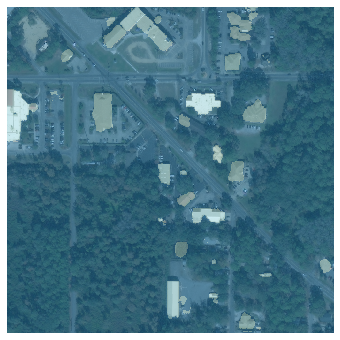

In [23]:
_, ax = plt.subplots(figsize=(6, 6))
img.show(ax)
y_mask.show(ax, alpha=.5)

### Building mask -> polygons

In [24]:
_, polys = bmask2polys(y_mask.data[0].numpy())

In [25]:
type(polys), len(polys)

(numpy.ndarray, 96)

### Generate unique ids for polygons

In [26]:
#export
def generate_uid_polys(polys): return np.array([str(uuid4()) for _ in polys])

In [27]:
uids = generate_uid_polys(polys)

### Get polygon images

In [28]:
path = Path('tmp_polyimgs')

In [30]:
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path, exist_ok=True)

In [31]:
img = open_image(posimgs[idx])

In [32]:
for uid, p in zip(uids, polys):
    polyimg = crop_by_polygon(img, p)
    polyimg.save(path/f'{uid}.png')

Refactor into function.

In [33]:
def polyimgs2disk(img, polys, path=None):
    if path is None: path = Path('tmp_polyimgs')
    shutil.rmtree(path, ignore_errors=True); os.makedirs(path, exist_ok=True)
    if len(polys) == 0: return path, []
    uids = generate_uid_polys(polys)
    for uid, p in zip(uids, polys): crop_by_polygon(img, p).save(path/f'{uid}.png')
    return path, uids

In [34]:
path, uids = polyimgs2disk(img, polys, path)

In [35]:
len(path.ls()), len(uids)

(96, 96)

### Damage classification

In [36]:
#damglearn.load('classifier_sz512_bs32_resnet50_stage1');  #'damg_classifier_sz64.pth'); #
#damglearn.export('damage_classifier.pkl')

In [37]:
%%time
il = ImageList([path/f'{uid}.png' for uid in uids])
damglearn = load_learner('./', file='damage_classifier.pkl', test=il)

CPU times: user 140 ms, sys: 60 ms, total: 200 ms
Wall time: 986 ms


In [38]:
len(il.items)

96

In [39]:
%%time
pred_damg, y_damg = damglearn.get_preds(ds_type=DatasetType.Test)

CPU times: user 628 ms, sys: 548 ms, total: 1.18 s
Wall time: 2.02 s


In [40]:
pred_classes = [damglearn.data.classes[i] for i in pred_damg.argmax(dim=1)]

In [41]:
pred_classes[3], pred_damg[3] #, y_damg[3], y_damg.sum()

('minor-damage', tensor([0.0841, 0.8678, 0.0392, 0.0089]))

In [42]:
#%%time
#preds, pred_classes = [], []
#for uid in progress_bar(uids):
#    polyimg = open_image(path/f'{uid}.png')
#    pred_class, pred_idx, outputs = damglearn.predict(polyimg)
#    preds.append(list(to_np(outputs)))
#    pred_classes.append(str(pred_class))

In [43]:
len(pred_classes), len(uids), len(polys), img

(96, 96, 96, Image (3, 1024, 1024))

Refactor into function.

In [45]:
def assess_damage_polyimgs(polyimgs, path='./', file='./damage_classifier.pkl'):
    if len(polyimgs.items) == 0: return [] # Need `.items` because `len(ImageList)` is 1 for empty list.
    damglearn = load_learner(path, file, test=polyimgs)
    pred_damg, _ = damglearn.get_preds(ds_type=DatasetType.Test)
    return [damglearn.data.classes[o] for o in pred_damg.argmax(dim=1)]

In [46]:
polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
damgs = assess_damage_polyimgs(polyimgs)

In [47]:
damgs[3], len(damgs)

('minor-damage', 96)

### Damage mask

In [48]:
DAMG_OTOI = {damg:i + 1 for i, damg in enumerate(damglearn.data.classes)}

In [49]:
DAMG_OTOI

{'no-damage/un-classified': 1,
 'minor-damage': 2,
 'major-damage': 3,
 'destroyed': 4}

In [50]:
damgmask = np.zeros(img.shape[1:], dtype=np.uint8)

In [51]:
for damg, poly in zip(damgs, polys):
    cv2.fillPoly(damgmask, poly[None,...], (DAMG_OTOI[damg]))
    
damgmask = ImageSegment(tensor(damgmask[None,...]))

Refactor into function.

In [52]:
def damgpolys2damgmask(polys, damgs, sz=1024):
    assert len(polys) == len(damgs)
    if isinstance(sz, int): sz = (sz, sz)
    mask = np.zeros(sz, dtype=np.uint8)
    if len(polys) > 0:
        for damg, poly in zip(damgs, polys): 
            cv2.fillPoly(mask, poly[None,...], (DAMG_OTOI[damg]))
    return ImageSegment(tensor(mask[None,...]))

In [53]:
damgmask = damgpolys2damgmask(polys, damgs, img.shape[1:])

In [55]:
damgmask.data.unique()

tensor([0, 2])

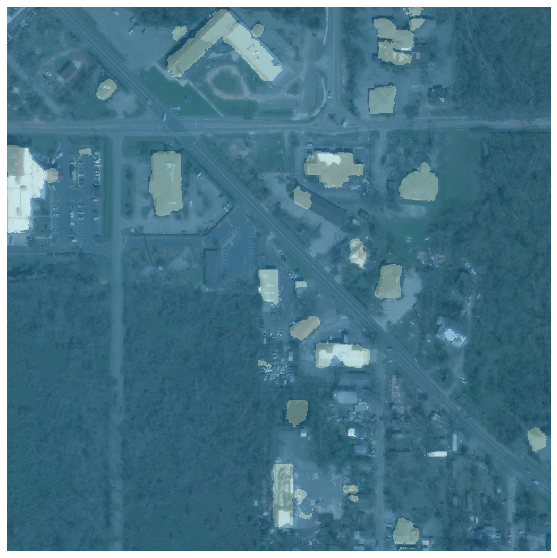

In [56]:
_, ax = plt.subplots(figsize=(10, 10))
img.show(ax)
damgmask.show(ax, alpha=.5)

### Pipeline

In [58]:
def infer_sample(path_preimg, path_posimg, seglearn, path_damglearn='./damage_classifier.pkl'):
    img = open_image(path_preimg)
    y_mask, _, _ = seglearn.predict(img)
    _, polys = bmask2polys(y_mask.data[0].numpy())
    img = open_image(path_posimg)
    path, uids = polyimgs2disk(img, polys, path=Path('tmp_polyimgs'))
    polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
    damgs = assess_damage_polyimgs(polyimgs, file=path_damglearn)
    damgmask = damgpolys2damgmask(polys, damgs, sz=img.shape[1:])
    return damgmask

def get_imgid(imgname): return imgname.stem.split('_')[-1]

In [59]:
path_results = Path('./inference_results')

In [60]:
os.makedirs(path_results, exist_ok=True)

Takes about 40 minutes to generate the inference .pngs.

In [74]:
for idx in progress_bar(range(len(preimgs))):
    npre, npos = preimgs[idx], posimgs[idx]
    damgmask = infer_sample(npre, npos, seglearn, './damage_classifier.pkl')
    imgid = get_imgid(npre)
    damgmask.save(path_results/f'test_localization_{imgid}_prediction.png')
    damgmask.save(path_results/f'test_damage_{imgid}_prediction.png')

In [94]:
imgid = '00919'
# imgid = '00064'  no buildings


In [95]:
len(get_image_files(path_results))
get_image_files(path_results)[:5]

[PosixPath('inference_results/test_localization_00536_prediction.png'),
 PosixPath('inference_results/test_damage_00313_prediction.png'),
 PosixPath('inference_results/test_damage_00142_prediction.png'),
 PosixPath('inference_results/test_localization_00376_prediction.png'),
 PosixPath('inference_results/test_damage_00919_prediction.png')]

In [96]:
path_local = path_results/f'test_localization_{imgid}_prediction.png'
path_damg = path_results/f'test_damage_{imgid}_prediction.png'

In [97]:
mask_local, mask_damg = open_mask(path_local), open_mask(path_damg)

In [98]:
mask_local.data.unique(), mask_damg.data.unique()

(tensor([0, 2]), tensor([0, 2]))

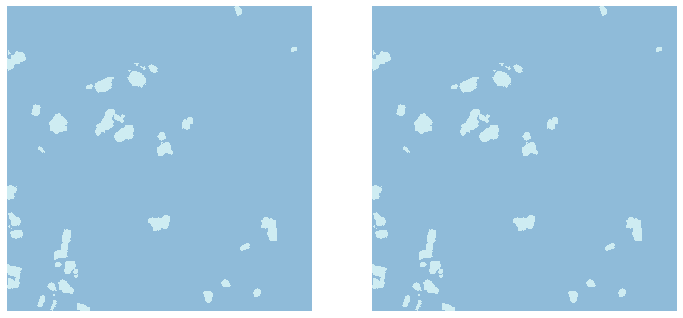

In [99]:
_, axs = plt.subplots(ncols=2, figsize=(12, 6))
open_mask(path_local).show(axs[0])
open_mask(path_damg).show(axs[1])

In [101]:
! tar czvf inference_results.tar.gz inference_results/

inference_results/
inference_results/test_localization_00536_prediction.png
inference_results/test_damage_00313_prediction.png
inference_results/test_damage_00142_prediction.png
inference_results/test_localization_00376_prediction.png
inference_results/test_damage_00919_prediction.png
inference_results/test_localization_00111_prediction.png
inference_results/test_localization_00065_prediction.png
inference_results/test_damage_00620_prediction.png
inference_results/test_localization_00315_prediction.png
inference_results/test_localization_00206_prediction.png
inference_results/test_localization_00556_prediction.png
inference_results/test_localization_00789_prediction.png
inference_results/test_localization_00435_prediction.png
inference_results/test_localization_00931_prediction.png
inference_results/test_damage_00161_prediction.png
inference_results/test_localization_00506_prediction.png
inference_results/test_localization_00501_prediction.png
inference_results/test_localization_00621_

inference_results/test_localization_00825_prediction.png
inference_results/test_localization_00712_prediction.png
inference_results/test_damage_00893_prediction.png
inference_results/test_damage_00505_prediction.png
inference_results/test_damage_00503_prediction.png
inference_results/test_damage_00682_prediction.png
inference_results/test_localization_00392_prediction.png
inference_results/test_damage_00897_prediction.png
inference_results/test_localization_00268_prediction.png
inference_results/test_damage_00241_prediction.png
inference_results/test_damage_00696_prediction.png
inference_results/test_localization_00132_prediction.png
inference_results/test_localization_00094_prediction.png
inference_results/test_localization_00328_prediction.png
inference_results/test_localization_00351_prediction.png
inference_results/test_localization_00398_prediction.png
inference_results/test_localization_00576_prediction.png
inference_results/test_damage_00817_prediction.png
inference_results/test

inference_results/test_localization_00743_prediction.png
inference_results/test_localization_00864_prediction.png
inference_results/test_damage_00466_prediction.png
inference_results/test_localization_00081_prediction.png
inference_results/test_localization_00774_prediction.png
inference_results/test_localization_00842_prediction.png
inference_results/test_damage_00092_prediction.png
inference_results/test_localization_00845_prediction.png
inference_results/test_damage_00408_prediction.png
inference_results/test_localization_00108_prediction.png
inference_results/test_localization_00706_prediction.png
inference_results/test_localization_00879_prediction.png
inference_results/test_damage_00836_prediction.png
inference_results/test_damage_00594_prediction.png
inference_results/test_localization_00114_prediction.png
inference_results/test_localization_00413_prediction.png
inference_results/test_damage_00106_prediction.png
inference_results/test_localization_00603_prediction.png
inference_

inference_results/test_damage_00476_prediction.png
inference_results/test_damage_00153_prediction.png
inference_results/test_localization_00782_prediction.png
inference_results/test_localization_00321_prediction.png
inference_results/test_damage_00627_prediction.png
inference_results/test_damage_00188_prediction.png
inference_results/test_localization_00468_prediction.png
inference_results/test_damage_00374_prediction.png
inference_results/test_localization_00150_prediction.png
inference_results/test_damage_00611_prediction.png
inference_results/test_damage_00860_prediction.png
inference_results/test_damage_00888_prediction.png
inference_results/test_localization_00650_prediction.png
inference_results/test_localization_00195_prediction.png
inference_results/test_damage_00850_prediction.png
inference_results/test_damage_00274_prediction.png
inference_results/test_damage_00781_prediction.png
inference_results/test_localization_00877_prediction.png
inference_results/test_localization_0027

inference_results/test_damage_00112_prediction.png
inference_results/test_localization_00822_prediction.png
inference_results/test_damage_00601_prediction.png
inference_results/test_damage_00823_prediction.png
inference_results/test_localization_00843_prediction.png
inference_results/test_damage_00882_prediction.png
inference_results/test_localization_00165_prediction.png
inference_results/test_damage_00299_prediction.png
inference_results/test_localization_00638_prediction.png
inference_results/test_damage_00522_prediction.png
inference_results/test_damage_00145_prediction.png
inference_results/test_localization_00079_prediction.png
inference_results/test_localization_00607_prediction.png
inference_results/test_localization_00790_prediction.png
inference_results/test_localization_00153_prediction.png
inference_results/test_localization_00575_prediction.png
inference_results/test_damage_00626_prediction.png
inference_results/test_localization_00155_prediction.png
inference_results/test

inference_results/test_localization_00482_prediction.png
inference_results/test_damage_00406_prediction.png
inference_results/test_localization_00701_prediction.png
inference_results/test_damage_00233_prediction.png
inference_results/test_localization_00505_prediction.png
inference_results/test_localization_00470_prediction.png
inference_results/test_localization_00545_prediction.png
inference_results/test_damage_00478_prediction.png
inference_results/test_localization_00532_prediction.png
inference_results/test_damage_00904_prediction.png
inference_results/test_damage_00432_prediction.png
inference_results/test_damage_00641_prediction.png
inference_results/test_localization_00049_prediction.png
inference_results/test_damage_00179_prediction.png
inference_results/test_localization_00427_prediction.png
inference_results/test_localization_00880_prediction.png
inference_results/test_damage_00397_prediction.png
inference_results/test_localization_00439_prediction.png
inference_results/test

inference_results/test_damage_00718_prediction.png
inference_results/test_damage_00815_prediction.png
inference_results/test_damage_00916_prediction.png
inference_results/test_damage_00201_prediction.png
inference_results/test_damage_00839_prediction.png
inference_results/test_damage_00071_prediction.png
inference_results/test_damage_00403_prediction.png
inference_results/test_damage_00310_prediction.png
inference_results/test_localization_00199_prediction.png
inference_results/test_localization_00119_prediction.png
inference_results/test_damage_00296_prediction.png
inference_results/test_damage_00728_prediction.png
inference_results/test_localization_00831_prediction.png
inference_results/test_localization_00190_prediction.png
inference_results/test_damage_00330_prediction.png
inference_results/test_damage_00428_prediction.png
inference_results/test_localization_00828_prediction.png
inference_results/test_localization_00362_prediction.png
inference_results/test_localization_00303_pred

inference_results/test_damage_00769_prediction.png
inference_results/test_localization_00154_prediction.png
inference_results/test_localization_00548_prediction.png
inference_results/test_localization_00710_prediction.png
inference_results/test_localization_00358_prediction.png
inference_results/test_localization_00441_prediction.png
inference_results/test_localization_00704_prediction.png
inference_results/test_localization_00776_prediction.png
inference_results/test_damage_00013_prediction.png
inference_results/test_damage_00171_prediction.png
inference_results/test_damage_00845_prediction.png
inference_results/test_damage_00895_prediction.png
inference_results/test_localization_00414_prediction.png
inference_results/test_localization_00080_prediction.png
inference_results/test_damage_00126_prediction.png
inference_results/test_damage_00088_prediction.png
inference_results/test_damage_00319_prediction.png
inference_results/test_damage_00802_prediction.png
inference_results/test_local

inference_results/test_localization_00223_prediction.png
inference_results/test_localization_00415_prediction.png
inference_results/test_localization_00715_prediction.png
inference_results/test_localization_00639_prediction.png
inference_results/test_localization_00810_prediction.png
inference_results/test_localization_00289_prediction.png
inference_results/test_localization_00314_prediction.png
inference_results/test_damage_00400_prediction.png
inference_results/test_damage_00551_prediction.png
inference_results/test_damage_00246_prediction.png
inference_results/test_localization_00756_prediction.png
inference_results/test_localization_00015_prediction.png
inference_results/test_localization_00619_prediction.png
inference_results/test_localization_00277_prediction.png
inference_results/test_damage_00915_prediction.png
inference_results/test_damage_00339_prediction.png
inference_results/test_localization_00460_prediction.png
inference_results/test_damage_00135_prediction.png
inference_

inference_results/test_damage_00058_prediction.png
inference_results/test_localization_00042_prediction.png
inference_results/test_damage_00102_prediction.png
inference_results/test_damage_00349_prediction.png
inference_results/test_localization_00565_prediction.png
inference_results/test_damage_00272_prediction.png
inference_results/test_localization_00085_prediction.png
inference_results/test_localization_00714_prediction.png
inference_results/test_localization_00121_prediction.png
inference_results/test_damage_00872_prediction.png
inference_results/test_damage_00459_prediction.png
inference_results/test_damage_00055_prediction.png
inference_results/test_localization_00055_prediction.png
inference_results/test_localization_00009_prediction.png
inference_results/test_localization_00348_prediction.png
inference_results/test_damage_00378_prediction.png
inference_results/test_localization_00149_prediction.png
inference_results/test_damage_00574_prediction.png
inference_results/test_damag

inference_results/test_localization_00927_prediction.png
inference_results/test_localization_00515_prediction.png
inference_results/test_localization_00535_prediction.png
inference_results/test_localization_00907_prediction.png
inference_results/test_localization_00642_prediction.png
inference_results/test_localization_00444_prediction.png
inference_results/test_localization_00145_prediction.png
inference_results/test_damage_00376_prediction.png
inference_results/test_damage_00358_prediction.png
inference_results/test_damage_00859_prediction.png
inference_results/test_localization_00249_prediction.png
inference_results/test_damage_00159_prediction.png
inference_results/test_localization_00711_prediction.png
inference_results/test_damage_00782_prediction.png
inference_results/test_localization_00484_prediction.png
inference_results/test_localization_00123_prediction.png
inference_results/test_damage_00643_prediction.png
inference_results/test_damage_00195_prediction.png
inference_result

In [103]:
! du -hs inference_results*

17M	inference_results
12M	inference_results.tar.gz


# - fin

In [222]:
! python notebook2script.py 03b_inference_pipeline.ipynb

Converted 03b_inference_pipeline.ipynb to xview2comp/nb_03b.py
